---

# 🌺 Анализ Поведения Пользователей YouTube через Кластеризацию Видео #

---

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import googleapiclient.discovery
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Шаг 1: Сбор и подгатовка данных с YouTube API

Для работы с YouTube API нам нужно будет создать проект на Google Developers Console и получить API ключ. Используем библиотеку google-api-python-client для взаимодействия с API.

После получения данных, необходимо их подготовить для последующей сегментации. Извлекаем необходимые параметры и создадим DataFrame.

In [4]:
# Установите ВАШ API КЛЮЧ
API_KEY = 'YOUR_API_KEY'

# Создание объекта для работы с API
youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=API_KEY)

In [ ]:
# Функция для извлечения информации о видео
def extract_video_info(video):
    video_id = video['id']['videoId']
    snippet = video['snippet']
    title = snippet['title']
    channel_title = snippet['channelTitle']
    publish_time = snippet['publishedAt']
    
    # Получение статистики видео
    video_request = youtube.videos().list(
        part="statistics",
        id=video_id
    )
    video_response = video_request.execute()
    stats = video_response['items'][0]['statistics']
    
    view_count = int(stats.get('viewCount', 0))
    like_count = int(stats.get('likeCount', 0))
    comment_count = int(stats.get('commentCount', 0))
    dislike_count = int(stats.get('dislikeCount', 0))  # Добавляем счетчик дизлайков
    
    return [video_id, title, channel_title, publish_time, view_count, like_count, comment_count, dislike_count]

# Извлечение информации о видео с учетом пагинации и учетом регистра
def extract_videos_with_pagination(max_results, query):
    total_results = []
    next_page_token = None
    
    while len(total_results) < max_results:
        # Выполнение запроса к API
        request = youtube.search().list(
            part="snippet",
            q=query.lower(),  # Ключевое слово для поиска в нижнем регистре
            maxResults=min(50, max_results - len(total_results)),  # Ограничение на количество результатов
            type="video",
            pageToken=next_page_token if next_page_token else None
        )
        response = request.execute()

        # Обработка полученных результатов
        items = response.get('items', [])
        for item in items:
            video_info = extract_video_info(item)
            total_results.append(video_info)
        
        # Проверка наличия следующей страницы
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break  # Выход из цикла, если больше нет страниц
    
    return total_results

# Извлечение информации о видео по запросу "Data analytics" (с учетом регистра)
video_data = extract_videos_with_pagination(max_results=10000, query="Data analytics")

# Создание DataFrame
columns = ['video_id', 'title', 'channel_title', 'publish_time', 'view_count', 'like_count', 'comment_count', 'dislike_count']
df = pd.DataFrame(video_data, columns=columns)

# Шаг 2: Обработка и Сегментация данных

Теперь, когда данные подготовлены, применим метод K-средних (K-means) для сегментации видео на основе количества просмотров, лайков и комментариев.

После сегментации необходимо интерпретировать результаты и сделать выводы о характеристиках каждого кластера.

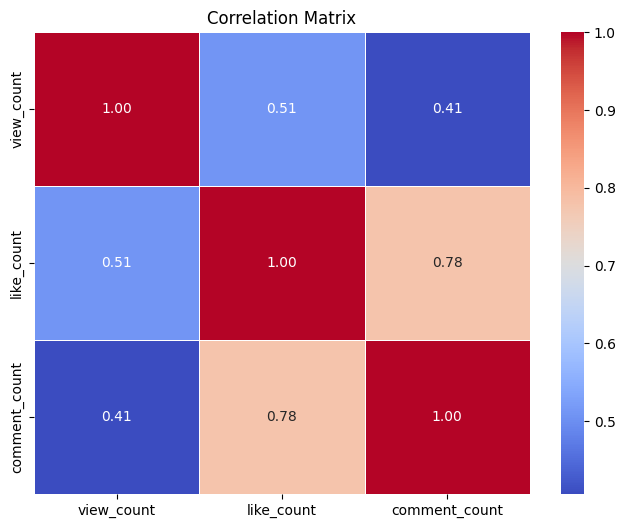

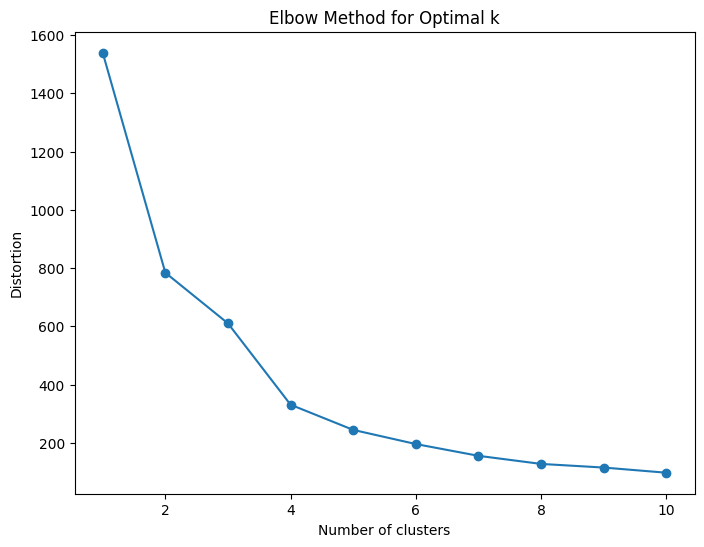

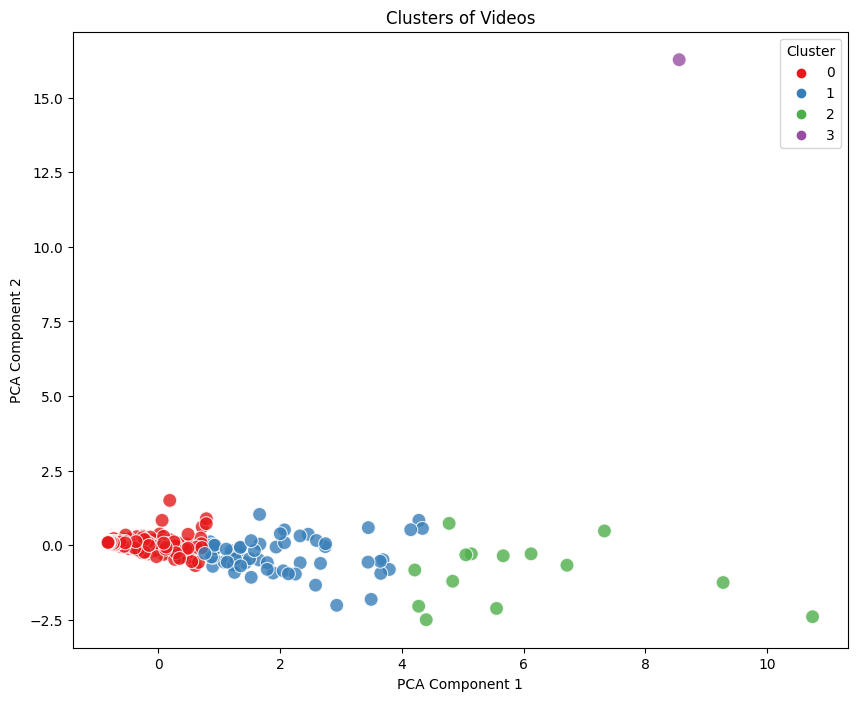

,view_count,like_count,comment_count,like_view_ratio,comment_view_ratio
cluster,,,,,
0,1.406794e+05,3573.486301,118.739726,0.035796,2.261972e-03
1,1.095860e+06,33935.433333,850.183333,0.034174,1.126653e-03
2,2.734076e+06,76775.500000,2210.142857,0.030572,1.082816e-03
3,2.048684e+07,1329.000000,19.000000,0.000065,9.274246e-07


In [12]:
# Подготовка данных
# Удаление дубликатов и неполных записей (если еще не сделано)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Преобразование формата даты и времени
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Создание новых признаков
df['like_view_ratio'] = df['like_count'] / df['view_count']
df['comment_view_ratio'] = df['comment_count'] / df['view_count']

# Визуализация данных: матрица корреляции
correlation_matrix = df[['view_count', 'like_count', 'comment_count']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Стандартизация данных
scaler = StandardScaler()
X = scaler.fit_transform(df[['view_count', 'like_count', 'comment_count']])

# Определение оптимального числа кластеров методом локтя
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

# Видим, что $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 с 2 до 3 и с 3 до 4
#и уже не так сильно – при изменении k с 4 до 5. Значит, в данной задаче оптимально задать 4 кластера
#Убедится в этом можно посмотрев на график
# Выбор числа кластеров (k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_

# Понижение размерности для визуализации кластеров (метод PCA)
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)
df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

# Визуализация кластеров
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1', s=100, alpha=0.8)
plt.title('Clusters of Videos')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Интерпретация результатов кластеризации
cluster_summary = df.groupby('cluster')[['view_count', 'like_count', 'comment_count', 'like_view_ratio', 'comment_view_ratio']].mean()
cluster_summary

# Результаты
### Матрица корреляции:
- Между количеством просмотров, лайков и комментариев наблюдается умеренная положительная корреляция.
- Наиболее сильная корреляция наблюдается между лайками и комментариями (коэффициент корреляции = 0.78).

### Оптимальное число кластеров:
- Метод локтя показал, что оптимальное количество кластеров равно 4.

### Визуализация кластеров:
- Визуализация кластеров показала четкое разделение видео на четыре группы.
- График PCA продемонстрировал, что кластеры имеют различное распределение по метрикам.

### Описание кластеров:
- Кластер 0: Видео с наименьшим средним количеством просмотров, лайков и комментариев.
- Кластер 1: Видео со средним количеством просмотров, лайков и комментариев.
- Кластер 2: Видео с высоким количеством просмотров, лайков и комментариев.
- Кластер 3: Видео с наибольшим количеством просмотров, но относительно низким количеством лайков и комментариев.



# Выводы
- Наиболее популярные видео (кластер 3) имеют огромное количество просмотров, но относительно небольшое количество лайков и комментариев, что может указывать на их более широкий охват, но меньшую вовлеченность пользователей.
- Видео из кластеров 0, 1 и 2 показывают более сбалансированное соотношение просмотров, лайков и комментариев, что может свидетельствовать о более высокой вовлеченности пользователей.
- Понимание распределения этих метрик может помочь авторам контента и маркетологам разрабатывать более эффективные стратегии для увеличения вовлеченности и популярности их видео.

### Рекомендации
- Для увеличения вовлеченности пользователей, авторам контента стоит обратить внимание на видео, попавшие в кластеры с высоким соотношением лайков и комментариев к просмотрам.

- Маркетологи могут использовать результаты анализа для таргетинга и создания рекламных кампаний, ориентированных на видео с высоким уровнем вовлеченности.


Этот проект демонстрирует, как методы машинного обучения и анализа данных могут быть использованы для получения ценной информации из больших объемов данных, таких как данные о видео на YouTube.